<a href="https://colab.research.google.com/github/karipuf/crypto/blob/master/Cryptooo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setting stuff up

In [ ]:
!pip install Historic-Crypto
!pip install pyspark


In [61]:
from Historic_Crypto import HistoricalData,Cryptocurrencies,LiveCryptoData
import pylab as pl
import pyspark,lightgbm,sklearn,pandas as pd,pyspark.sql.functions as F
from pyspark.sql.window import Window

spark=pyspark.sql.SparkSession.builder.getOrCreate()

In [ ]:
# Local definitions


### Get some data to play about with

In [ ]:
# Something weird
pf=Cryptocurrencies().find_crypto_pairs()

Connected to the CoinBase Pro API.


In [ ]:
btc = HistoricalData('BTC-USD',300,'2020-06-01-00-00').retrieve_data()
btc.to_csv("btc.csv")

In [ ]:
eth = HistoricalData('ETH-USD',300,'2020-06-01-00-00').retrieve_data()
eth.to_csv("eth.csv")

In [ ]:
eth.head(5)

,low,high,open,close,volume
time,,,,,
2020-06-01 00:05:00,230.91,232.51,231.09,232.30,1046.811509
2020-06-01 00:10:00,232.31,233.21,232.34,232.92,598.474297
2020-06-01 00:15:00,232.81,233.68,232.87,233.07,599.021589
2020-06-01 00:20:00,232.81,233.28,233.07,233.04,587.719808
2020-06-01 00:25:00,232.91,233.30,233.04,233.25,345.725075


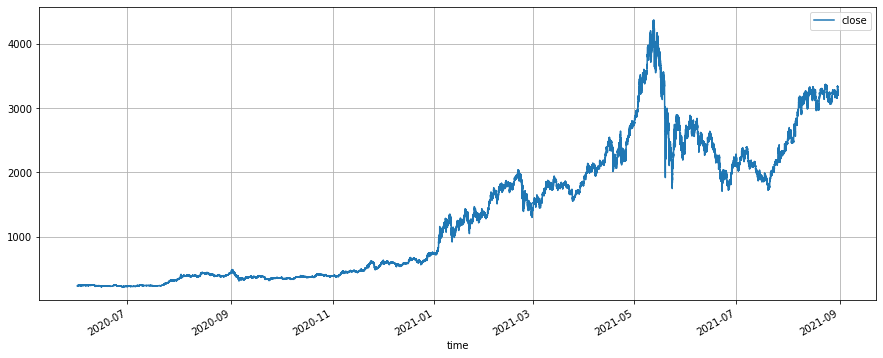

In [ ]:
pl.figure(figsize=(15,6))
eth.plot(y='close',ax=pl.gca())
pl.gca().grid(True)

In [ ]:
eth.to_csv("eth.csv")

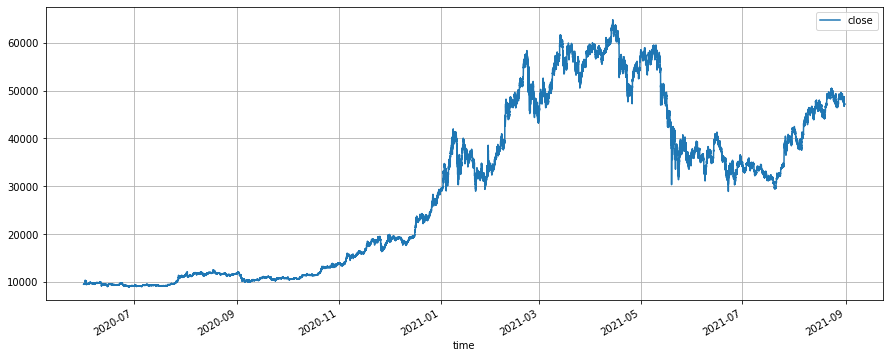

In [ ]:
pl.figure(figsize=(15,6))
btc.plot(y='close',ax=pl.gca())
pl.gca().grid(True)

In [97]:
deth=spark.createDataFrame(eth.reset_index())
dbtc=spark.createDataFrame(btc.reset_index())

combined=(deth.alias("deth")
.join(dbtc.alias("dbtc"),"time")
.select(
    deth.time,
    *[F.expr(f"deth.{tmp}").alias(f"eth_{tmp}") for tmp in ('close','volume','low','high')],
    *[F.expr(f"dbtc.{tmp}").alias(f"btc_{tmp}") for tmp in ('close','volume','low','high')])
.orderBy("time"))

In [98]:
display(combined.limit(5).toPandas())

,time,eth_close,eth_volume,eth_low,eth_high,btc_close,btc_volume,btc_low,btc_high
0,2020-06-01 00:05:00,232.30,1046.811509,230.91,232.51,9469.01,40.716165,9426.26,9470.99
1,2020-06-01 00:10:00,232.92,598.474297,232.31,233.21,9476.77,44.604356,9468.07,9488.16
2,2020-06-01 00:15:00,233.07,599.021589,232.81,233.68,9476.85,38.898090,9475.30,9492.77
3,2020-06-01 00:20:00,233.04,587.719808,232.81,233.28,9479.78,28.145373,9469.25,9481.98
4,2020-06-01 00:25:00,233.25,345.725075,232.91,233.30,9483.69,23.093949,9471.12,9483.72


In [99]:
rollback=lambda l,n:Window.orderBy("time").rowsBetween(-(l+n),Window.currentRow-n)

rows=([F.avg(tmp).over(rollback(3,3)).alias(f"{tmp}_rolling3")
for tmp in ("eth_close","eth_volume","btc_close","btc_volume")]
+[F.avg(tmp).over(rollback(7,3)).alias(f"{tmp}_rolling7")
for tmp in ("eth_close","eth_volume","btc_close","btc_volume")]
)

x=combined.alias("combined").select("combined.*",*rows).orderBy("time")

In [88]:
df.columns

['time',
 'eth_close',
 'eth_volume',
 'btc_close',
 'btc_volume',
 'eth_close_rolling3',
 'eth_volume_rolling3',
 'btc_close_rolling3',
 'btc_volume_rolling3',
 'eth_close_rolling7',
 'eth_volume_rolling7',
 'btc_close_rolling7',
 'btc_volume_rolling7']

### Scratch

In [ ]:
import requests
response = requests.get('https://api.coindesk.com/v1/bpi/currentprice.json')
data = response.json()
print(data)

{'time': {'updated': 'Aug 31, 2021 05:49:00 UTC', 'updatedISO': '2021-08-31T05:49:00+00:00', 'updateduk': 'Aug 31, 2021 at 06:49 BST'}, 'disclaimer': 'This data was produced from the CoinDesk Bitcoin Price Index (USD). Non-USD currency data converted using hourly conversion rate from openexchangerates.org', 'chartName': 'Bitcoin', 'bpi': {'USD': {'code': 'USD', 'symbol': '&#36;', 'rate': '47,195.4600', 'description': 'United States Dollar', 'rate_float': 47195.46}, 'GBP': {'code': 'GBP', 'symbol': '&pound;', 'rate': '34,250.5476', 'description': 'British Pound Sterling', 'rate_float': 34250.5476}, 'EUR': {'code': 'EUR', 'symbol': '&euro;', 'rate': '39,935.0992', 'description': 'Euro', 'rate_float': 39935.0992}}}
